# LSTM for Production-Multivariate

In this repo, we will use the production data of the [Equinor’s Volve data set](https://www.equinor.com/energy/volve-data-sharing), a publicly available subsurface data set, to predict oil, gas, and water production.

If you are using Colab to run this notebook, you have to run the below cell. Change the `content/drive/My Drive` according to your directly. If you are running this notebook on a local environment i.e. Anaconda or VS code, ignore the below cell. But make sure your notebook and dataset are in the same directory.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive')
os.path.exists('/content/drive/My Drive')

Mounted at /content/drive


True

First, import the libraries and framework to use.  
I am using `random seed 42` to reproduce the same random number everytime I run the code.

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
tf.keras.utils.set_random_seed(42)

Now import the Excel file named `Volve_production_data` which contains our data.  
Take a moment to understand the data.

In [4]:
full_data = pd.read_excel('Volve_production_data.xlsx')
full_data

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,...,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15629,2016-09-14,NO 15/9-F-5 AH,5769,15/9-F-5,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.07776,0.22879,0.01862,0.0,0.0,0.0,NaN,production,OP
15630,2016-09-15,NO 15/9-F-5 AH,5769,15/9-F-5,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.08545,0.22914,0.00631,0.0,0.0,0.0,NaN,production,OP
15631,2016-09-16,NO 15/9-F-5 AH,5769,15/9-F-5,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.08544,0.22896,0.01181,0.0,0.0,0.0,NaN,production,OP
15632,2016-09-17,NO 15/9-F-5 AH,5769,15/9-F-5,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.07497,0.22846,0.02576,0.0,0.0,0.0,NaN,production,OP


Let's print out the names of all columns.

In [5]:
column_names = full_data.columns
print(column_names)

Index(['DATEPRD', 'WELL_BORE_CODE', 'NPD_WELL_BORE_CODE', 'NPD_WELL_BORE_NAME',
       'NPD_FIELD_CODE', 'NPD_FIELD_NAME', 'NPD_FACILITY_CODE',
       'NPD_FACILITY_NAME', 'ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE',
       'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS',
       'AVG_CHOKE_SIZE_P', 'AVG_CHOKE_UOM', 'AVG_WHP_P', 'AVG_WHT_P',
       'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL',
       'BORE_WI_VOL', 'FLOW_KIND', 'WELL_TYPE'],
      dtype='object')


The Vovle dataset has around 40,000 files, including:

* Geophysical data, including interpretations
* Geo-Science Archive
* Production data
* Report
* Static models and dynamic simulations
* Seismic data
* Well logs
* Well Technical Data
* Realtime drilling data  

To optimize model performance, it is essential to extract all the relevant features from the dataset. This involves both spatial (static) and temporal (dynamic) data. For example, extracting features from the Surface Operational Conditions, Details of all Wells Architecture, Well Logs, Core Analysis, Well Tests, Seismic, Production Logs, Temperature Survey, Production/Injection History, etc. to build a comprehensive reservoir model.

However, feature extraction is itself a comprehensive topic, and for the purpose of this discussion, my focus is on the machine learning (ML) aspect rather than delving deep into feature extraction. Therefore, we will use only dynamic (production) data such as: `ON_STREAM_HRS, AVG_DOWNHOLE_PRESSURE, AVG_DOWNHOLE_TEMPERATURE, AVG_DP_TUBING, AVG_ANNULUS_PRESS, AVG_CHOKE_SIZE_P, AVG_CHOKE_UOM, AVG_WHP_P, AVG_WHT_P, DP_CHOKE_SIZE,` `BORE_OIL_VOL`, `BORE_GAS_VOL`, and `BORE_WAT_VOL` to train our LSTM model.


Let's see the names of different wells and their types:

In [6]:
unique_well_bore = full_data['NPD_WELL_BORE_NAME'].unique()
print("All Unique Well Bore Names:")
print(unique_well_bore)

unique_producer_well_bore = full_data[full_data['FLOW_KIND'] == 'production']['NPD_WELL_BORE_NAME'].unique()
print("\nWell Bore Names for 'production':")
print(unique_producer_well_bore)

unique_injection_well_bore = full_data[full_data['FLOW_KIND'] == 'injection']['NPD_WELL_BORE_NAME'].unique()
print("\nWell Bore Names for 'injection':")
print(unique_injection_well_bore)


All Unique Well Bore Names:
['15/9-F-1 C' '15/9-F-11' '15/9-F-12' '15/9-F-14' '15/9-F-15 D' '15/9-F-4'
 '15/9-F-5']

Well Bore Names for 'production':
['15/9-F-1 C' '15/9-F-11' '15/9-F-12' '15/9-F-14' '15/9-F-15 D' '15/9-F-5']

Well Bore Names for 'injection':
['15/9-F-4' '15/9-F-5']


Notice that Well 15/9-F-5 is on both list (production and injection). Because it was a water injector and then was converted into an oil producer on April 11, 2016. Moreover, the longest-producing wells are 15/9-F-12 and 15/9-F-14. See [this dissertation](https://researchrepository.wvu.edu/etd/11970/) for more details.

The below cell will sort the data in chronological order:

In [7]:
full_data = full_data.sort_values(by='DATEPRD')

Now define our data to use. I will use the data of the longest producing well (15/9-F-12), but if you want to use the full data, you just need to uncomment the Full data code and comment out the F-12 data code.  
The `DATEPRD` column is only for plotting purposes.

In [8]:
# F-12 data
data = full_data[(full_data['NPD_WELL_BORE_NAME'] == '15/9-F-12')][['DATEPRD', 'ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL','BORE_GAS_VOL', 'BORE_WAT_VOL']]

# Full data
#data = full_data[['DATEPRD', 'ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL','BORE_GAS_VOL', 'BORE_WAT_VOL']]


Let's check the summary of our data.

In [9]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ON_STREAM_HRS,3056.0,21.336410,6.889150,0.00,24.000000,24.000000,24.000000,25.000000
AVG_DOWNHOLE_PRESSURE,3050.0,80.729072,120.086902,0.00,0.000000,0.000000,239.422752,317.701150
AVG_DOWNHOLE_TEMPERATURE,3050.0,33.292076,49.354533,0.00,0.000000,0.000000,106.048231,107.507552
AVG_DP_TUBING,3050.0,84.765924,72.511534,0.00,32.454825,38.721292,171.190061,314.409160
AVG_ANNULUS_PRESS,3043.0,17.272199,6.396437,0.00,13.975764,18.660021,20.825525,30.019828
AVG_CHOKE_SIZE_P,3012.0,69.254352,30.179952,0.00,48.894109,70.724595,99.998130,100.000000
AVG_WHP_P,3056.0,47.973013,24.305518,0.00,32.421836,38.445743,59.598066,137.311030
AVG_WHT_P,3056.0,78.623925,20.275990,0.00,78.420291,82.924712,90.159986,92.458642
DP_CHOKE_SIZE,3056.0,19.292670,22.750867,0.00,3.966373,7.502564,27.428521,124.122990
BORE_OIL_VOL,3056.0,1498.563334,1662.851799,0.00,266.222500,697.655000,2404.467500,5901.840000


Notice that we have a negative value (-457.84) in the `BORE_WAT_VOL`. Replace it with zero as negative production is not possible.

In [10]:
mask = data.select_dtypes(exclude=[np.datetime64]).lt(0)
data.loc[:, mask.columns] = data.loc[:, mask.columns].mask(mask, 0)

Let's see how many samples we have:

In [11]:
print(f'We have {data.shape[0]} samples')

We have 3056 samples


Check if this **3056** has any null values

In [12]:
null_values = data.isnull().sum()
print("Null values:")
print(null_values)

Null values:
DATEPRD                      0
ON_STREAM_HRS                0
AVG_DOWNHOLE_PRESSURE        6
AVG_DOWNHOLE_TEMPERATURE     6
AVG_DP_TUBING                6
AVG_ANNULUS_PRESS           13
AVG_CHOKE_SIZE_P            44
AVG_WHP_P                    0
AVG_WHT_P                    0
DP_CHOKE_SIZE                0
BORE_OIL_VOL                 0
BORE_GAS_VOL                 0
BORE_WAT_VOL                 0
dtype: int64


Alright, we have 6 null values for `AVG_DOWNHOLE_PRESSURE`, `AVG_DOWNHOLE_TEMPERATURE`, `AVG_DP_TUBING` and 13 & 44 null values in `AVG_ANNULUS_PRESS` and `AVG_CHOKE_SIZE_P`.

You may want to use different methods to patch the missing values but, I am simply deleting these cells as they are only 2% of the total data.  
The below code will delete all the null values.

In [13]:
data = data.dropna()
null_values = data.isnull().sum()
print("Null values:")
print(null_values)

Null values:
DATEPRD                     0
ON_STREAM_HRS               0
AVG_DOWNHOLE_PRESSURE       0
AVG_DOWNHOLE_TEMPERATURE    0
AVG_DP_TUBING               0
AVG_ANNULUS_PRESS           0
AVG_CHOKE_SIZE_P            0
AVG_WHP_P                   0
AVG_WHT_P                   0
DP_CHOKE_SIZE               0
BORE_OIL_VOL                0
BORE_GAS_VOL                0
BORE_WAT_VOL                0
dtype: int64


Let's see our data:

In [14]:
data

,DATEPRD,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL
1911,2008-02-12,11.50,308.055940,104.418090,201.250000,18.639557,14.484431,106.805939,16.294718,92.475107,284.65,38888.67,385.01
1912,2008-02-13,24.00,303.033518,105.402696,182.144942,16.466641,22.832986,120.888576,53.374330,89.620148,1869.70,285246.16,7.13
1913,2008-02-14,22.50,295.586061,105.775486,181.867887,12.659589,31.249966,113.718175,72.737631,80.120465,3124.09,509954.88,1.16
1914,2008-02-15,23.15,297.662702,105.751875,180.832060,5.264052,28.518930,116.830642,69.995943,84.250990,2608.28,383426.67,0.97
1915,2008-02-16,24.00,295.935519,105.811114,180.501045,12.384634,30.227902,115.434474,71.518347,82.359026,3051.80,418474.00,4.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4962,2016-09-13,0.00,0.000000,0.000000,0.000000,19.958840,0.992907,0.000000,0.000000,0.012620,0.00,0.00,0.00
4963,2016-09-14,0.00,0.000000,0.000000,0.000000,19.958630,0.973044,0.000000,0.000000,0.015740,0.00,0.00,0.00
4964,2016-09-15,0.00,0.000000,0.000000,0.000000,19.958870,0.977784,0.000000,0.000000,0.023690,0.00,0.00,0.00
4965,2016-09-16,0.00,0.000000,0.000000,0.000000,19.958730,0.961007,0.000000,0.000000,0.024660,0.00,0.00,0.00


So, we have now zero null values, **2993** samples and 13 columns. Remember that the date column is only for plotting purpose, so, we have **12** features.

Let's plot the oil (`BORE_OIL_VOL`), gas (`BORE_GAS_VOL`), and water production (`BORE_WAT_VOL`) against the date (`DATEPRD`).

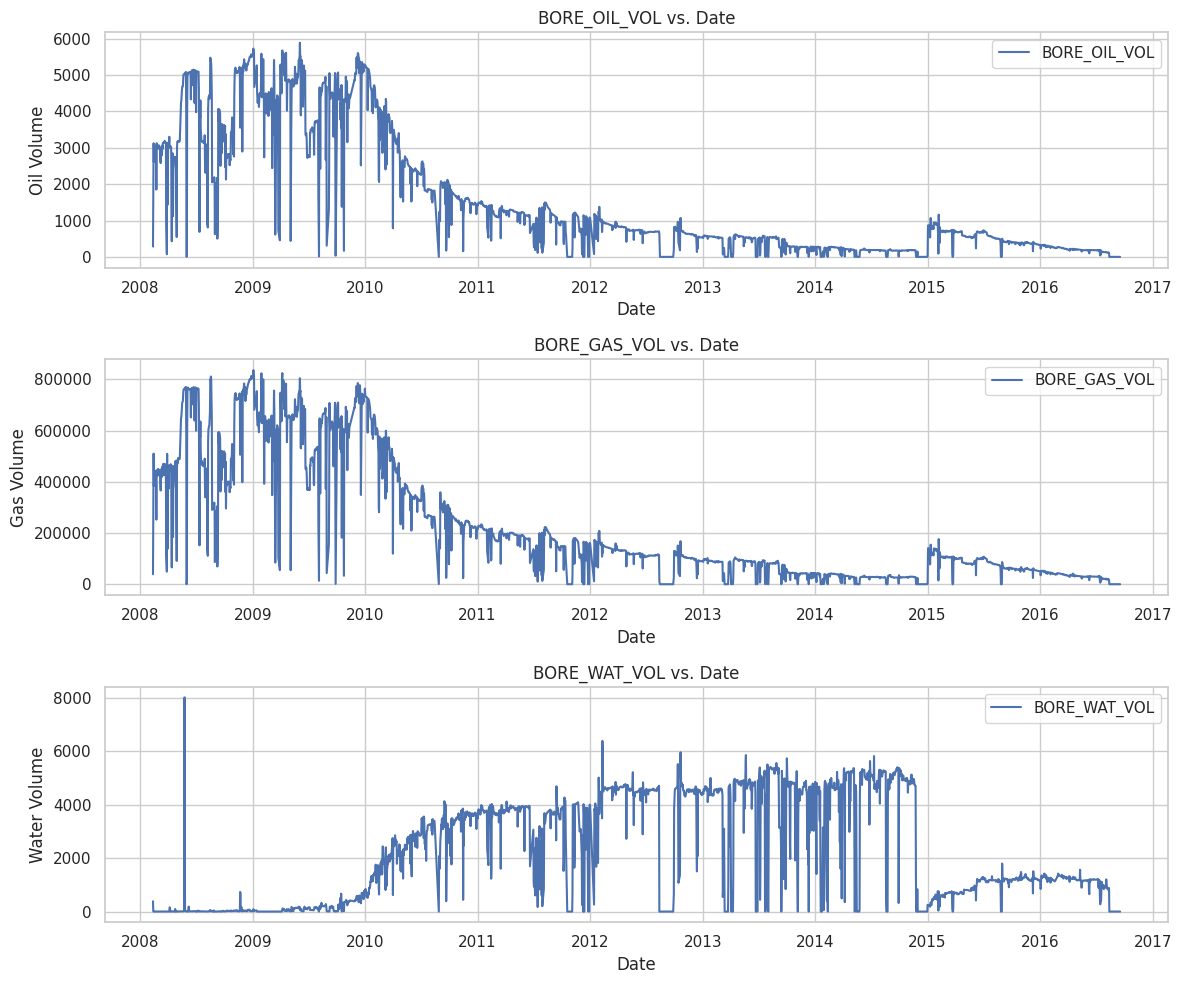

In [15]:
sns.set(style="whitegrid")
fig, axs = plt.subplots(3, 1, figsize=(12, 10))

# Plot BORE_OIL_VOL
sns.lineplot(data=data, x='DATEPRD', y='BORE_OIL_VOL', ax=axs[0])
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Oil Volume')
axs[0].set_title('BORE_OIL_VOL vs. Date')

# Plot BORE_GAS_VOL
sns.lineplot(data=data, x='DATEPRD', y='BORE_GAS_VOL', ax=axs[1])
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Gas Volume')
axs[1].set_title('BORE_GAS_VOL vs. Date')

# Plot BORE_WAT_VOL
sns.lineplot(data=data, x='DATEPRD', y='BORE_WAT_VOL', ax=axs[2])
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Water Volume')
axs[2].set_title('BORE_WAT_VOL vs. Date')

axs[0].legend(['BORE_OIL_VOL'])
axs[1].legend(['BORE_GAS_VOL'])
axs[2].legend(['BORE_WAT_VOL'])
plt.tight_layout()
plt.show()


Notice that we have outliers in water production between 2008 and 2009. Let's find out how many these are and delete them.

In [16]:
for i, max_val in enumerate(data['BORE_WAT_VOL'].nlargest(5), 1):
    print(f"Top {i} Max BORE_WAT_VOL: {max_val}")

Top 1 Max BORE_WAT_VOL: 8019.74
Top 2 Max BORE_WAT_VOL: 8019.72
Top 3 Max BORE_WAT_VOL: 6391.89
Top 4 Max BORE_WAT_VOL: 6109.26
Top 5 Max BORE_WAT_VOL: 5965.16


Delete the first two max values of water production (outliers).

In [17]:
max_indices_to_drop = data['BORE_WAT_VOL'].nlargest(2).index
data = data.drop(max_indices_to_drop)

Now we will use `MinMaxScaler` of sklearn to scale our features.

In [18]:
tf.keras.utils.set_random_seed(42)
from sklearn.preprocessing import MinMaxScaler

columns_to_scale = ['ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL','BORE_GAS_VOL', 'BORE_WAT_VOL']
data_to_scale = data[columns_to_scale].copy()
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_to_scale)
data_scaled_df = pd.DataFrame(data_scaled, columns=columns_to_scale)

# Add the 'DATEPRD' column as the first column. Later, we will use it for plotting purpose.
data_scaled_df.insert(0, 'DATEPRD', data['DATEPRD'])

In [19]:
data_scaled_df

,DATEPRD,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL
0,NaT,0.460,0.978644,0.971263,0.719611,0.620908,0.144844,0.777839,0.176238,0.745028,0.048338,0.046519,0.060234
1,NaT,0.960,0.962689,0.980421,0.651296,0.548525,0.228330,0.880400,0.577278,0.722027,0.317507,0.341211,0.001115
2,NaT,0.900,0.939029,0.983889,0.650306,0.421708,0.312500,0.828179,0.786705,0.645493,0.530524,0.610007,0.000181
3,NaT,0.926,0.945627,0.983669,0.646602,0.175352,0.285189,0.850847,0.757051,0.678770,0.442930,0.458655,0.000152
4,NaT,0.960,0.940140,0.984220,0.645418,0.412548,0.302279,0.840679,0.773517,0.663528,0.518248,0.500578,0.000765
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986,2011-02-06,0.000,0.000000,0.000000,0.000000,0.664855,0.009929,0.000000,0.000000,0.000102,0.000000,0.000000,0.000000
2987,2011-02-07,0.000,0.000000,0.000000,0.000000,0.664848,0.009730,0.000000,0.000000,0.000127,0.000000,0.000000,0.000000
2988,2011-02-08,0.000,0.000000,0.000000,0.000000,0.664856,0.009778,0.000000,0.000000,0.000191,0.000000,0.000000,0.000000
2989,2011-02-09,0.000,0.000000,0.000000,0.000000,0.664852,0.009610,0.000000,0.000000,0.000199,0.000000,0.000000,0.000000


Our data has values between 0 and 1.

Here comes the important part:  
In LSTM, we feed the data of the previous time step and predict the target for the current time step. In our case, we will feed all the features, including oil, gas, and water production, of the previous time step (previous day) and we will predict the oil, gas, and water production for the current time step (for today).

So, let's divide our data into features and targets (labels). Later, we will use `windowed_dataset` function to have features for the previous time step and targets for current time step.

In [20]:
features = data_scaled_df[['ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL','BORE_GAS_VOL', 'BORE_WAT_VOL']]
target = data_scaled_df[['BORE_OIL_VOL','BORE_GAS_VOL', 'BORE_WAT_VOL']]

LSTM expects Numpy data type, so the below code will convert our data, DataFrame type, into Numpy data type.

In [21]:
features = features.to_numpy()
target = target.to_numpy()

Now we will use sklearn to split our data into 70% training, 15% validation, and 15% test data set.  
The below code will do that.

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_temp, Y_train, Y_temp = train_test_split(features, target, test_size=0.3, shuffle=False)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, shuffle=False)
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_val = np.array(X_val)
Y_val = np.array(Y_val)
X_test = np.array(X_test)
Y_test = np.array(Y_test)
print("Number of samples in train set:", X_train.shape[0])
print("Number of samples in validation set:", X_val.shape[0])
print("Number of samples in test set:", X_test.shape[0])

Number of samples in train set: 2093
Number of samples in validation set: 449
Number of samples in test set: 449


Alright! So for so good. Let's visualize our data after the split.

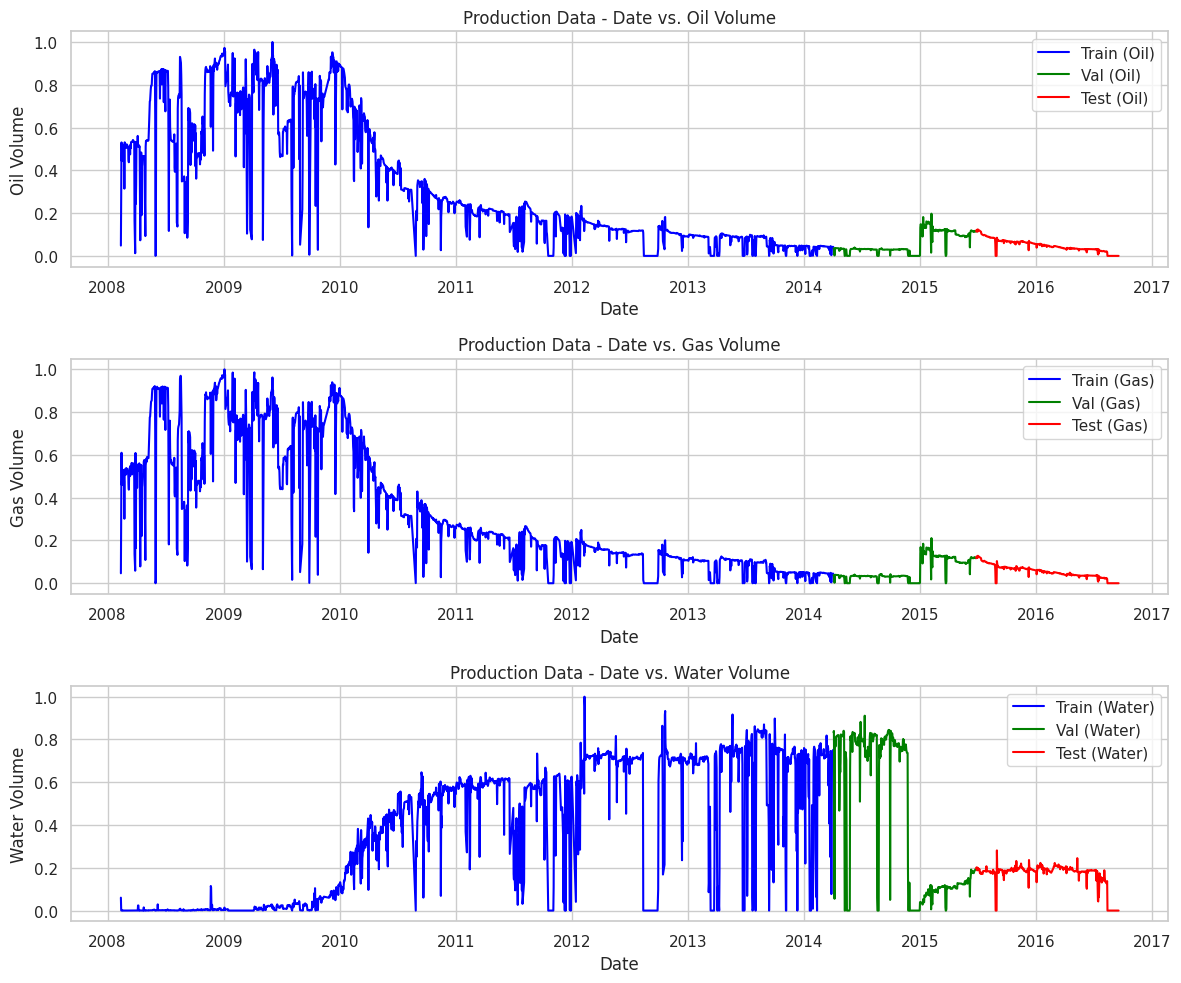

In [23]:
sns.set(style="whitegrid")
fig, axs = plt.subplots(3, 1, figsize=(12, 10))

# Plot Oil Production
sns.lineplot(data=data[:Y_train.shape[0]], x='DATEPRD', y=Y_train[:, 0], label='Train (Oil)', ax=axs[0], color='blue')
sns.lineplot(data=data[Y_train.shape[0]:Y_train.shape[0] + Y_val.shape[0]], x='DATEPRD', y=Y_val[:, 0], label='Val (Oil)', ax=axs[0], color='green')
sns.lineplot(data=data[Y_train.shape[0] + Y_val.shape[0]:], x='DATEPRD', y=Y_test[:, 0], label='Test (Oil)', ax=axs[0], color='red')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Oil Volume')
axs[0].set_title('Production Data - Date vs. Oil Volume')

# Plot Gas Production
sns.lineplot(data=data[:Y_train.shape[0]], x='DATEPRD', y=Y_train[:, 1], label='Train (Gas)', ax=axs[1], color='blue')
sns.lineplot(data=data[Y_train.shape[0]:Y_train.shape[0] + Y_val.shape[0]], x='DATEPRD', y=Y_val[:, 1], label='Val (Gas)', ax=axs[1], color='green')
sns.lineplot(data=data[Y_train.shape[0] + Y_val.shape[0]:], x='DATEPRD', y=Y_test[:, 1], label='Test (Gas)', ax=axs[1], color='red')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Gas Volume')
axs[1].set_title('Production Data - Date vs. Gas Volume')

# Plot Water Production
sns.lineplot(data=data[:Y_train.shape[0]], x='DATEPRD', y=Y_train[:, 2], label='Train (Water)', ax=axs[2], color='blue')
sns.lineplot(data=data[Y_train.shape[0]:Y_train.shape[0] + Y_val.shape[0]], x='DATEPRD', y=Y_val[:, 2], label='Val (Water)', ax=axs[2], color='green')
sns.lineplot(data=data[Y_train.shape[0] + Y_val.shape[0]:], x='DATEPRD', y=Y_test[:, 2], label='Test (Water)', ax=axs[2], color='red')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Water Volume')
axs[2].set_title('Production Data - Date vs. Water Volume')

plt.tight_layout()
plt.legend()
plt.show()


Okay! The below code will divide features and target into previous and current time step. This is the major concept of the LSTM.  

After experimentation, I found that using five time steps as input and a single time step as output gives the best result. So, our data will be:
* All the features (including oil, gas, and water production) of the five days (1st, 2nd, 3rd, 4th, and 5th days), target (oil, gas, and water production) of the 6th day
* Then all the features of the (2nd, 3rd, 4th, 5th, and 6th days), target (oil, gas, and water production) of the 7th day
* and so on...

If you are not familiar with the concept, I have an explanation of the code below. Please click on the green text "Click here for Explanation" and you will see the text. Click again and it will hide the text.

In [24]:
def windowed_dataset(features, target, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((features, target))
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda x, y: tf.data.Dataset.zip((x.batch(window_size + 1), y.batch(window_size + 1))))
    dataset = dataset.map(lambda x, y: (x[:-1], y[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

<details>
  <summary><font size="3" color="darkgreen"><b>Click here for Explanation</b></font></summary>
  
  Here's a step-by-step explanation of each part of the code:

`def windowed_dataset(features, target, window_size, batch_size):`
    This line defines a Python function named windowed_dataset that takes four arguments: features, target, window_size, and batch_size.

`dataset = tf.data.Dataset.from_tensor_slices((features, target))`
    This line creates a TensorFlow dataset using tf.data.Dataset.from_tensor_slices. It takes two arguments, features and target, and creates a dataset where each element is a pair consisting of a feature and its corresponding target. This is a common way to create a dataset from arrays.

`dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)`
This line applies a windowing operation to the dataset. It divides the dataset into overlapping windows of size `window_size + 1,` where window_size is a parameter provided to the function. The `shift=1` argument means that the windows will shift by one element at a time, creating overlapping windows. `drop_remainder=True` ensures that windows with fewer than `window_size + 1` elements are dropped.

`dataset = dataset.flat_map(lambda x, y: tf.data.Dataset.zip((x.batch(window_size + 1), y.batch(window_size + 1))))`
This line flattens the nested dataset created by the window operation. It uses flat_map to convert each window into a new dataset using a lambda function. Within this lambda function, x and y represent a window of features and target, respectively. `tf.data.Dataset.zip` is used to create pairs of (features_window, target_window), where each window contains `window_size + 1` elements. This essentially stacks the elements of each window together.

`dataset = dataset.map(lambda x, y: (x[:-1], y[-1]))`
This line maps a lambda function over the dataset to extract the input-output pairs for training. It takes each pair (features_window, target_window) and returns a new pair (input_sequence, target_sequence) where input_sequence include all time steps except the last one `(x[:-1])`, and target_sequence represents the values at the last time step `(y[-1])`. This prepares the data for a sequence prediction task where the model predicts the next element in a sequence based on the previous elements.

`dataset = dataset.batch(batch_size).prefetch(1)`
This line batches the dataset into mini-batches of size batch_size. Batching is commonly used in machine learning to process data in smaller chunks. The `prefetch(1)` operation prefetches one batch asynchronously to improve data loading efficiency.
return dataset

Finally, the function returns the prepared dataset, which is ready to be used for training a machine learning model.
</details>

Now apply the above function to our data.

In [25]:
tf.keras.utils.set_random_seed(42)
window_size = 5
batch_size = 32
train_set = windowed_dataset(X_train, Y_train, window_size, batch_size)
val_set = windowed_dataset(X_val, Y_val, window_size, batch_size)
test_set = windowed_dataset(X_test, Y_test, window_size, batch_size)

Now check the shape of our features and targets, after applying the window function.

In [26]:
train_iterator = iter(train_set)
first_element = next(train_iterator)
features_shape = first_element[0].shape
target_shape = first_element[1].shape

print("Features shape:", features_shape)
print("Target shape:", target_shape)

Features shape: (32, 5, 12)
Target shape: (32, 3)


The shape of **input** is **`(batch_size, window_size, features)`**  
The shape of **output** is **`(batch_size, target)`**

- `batch_size` is 32, which means we process 32 samples simultaneously.
- `window_size` is 5, indicating that each sample spans 5 time steps or days.
- `features` is 12, representing the number of input data points at each time step.
- `target` is 3, representing oil, gas, and water production for one time step.

To provide a clearer understanding, let's examine the sample data for the first batch. Run the below cell to see:

- We have the 5 time steps as input, each consisting of 12 features, and output is the single time step with 3 target values.
- It's important to note that out of 12 input data, the last three are oil, gas, and water production, respectively, of the previous day.
- **You can observe that the targets (oil, gas, and water production) for the current time step is become an input for the next time step.**
- **This pattern continues for subsequent time steps.**

In [27]:
first_sample = (first_element[0][0], first_element[1][0])
second_sample = (first_element[0][1], first_element[1][1])
third_sample = (first_element[0][2], first_element[1][2])

print(f"\033[1;34mInput Data, Five Time Step:\033[0m: {first_sample[0]}")
print(f"\033[1;34mOutput Data, One Time Step:\033[0m: {first_sample[1]}")
print()
print(f"\033[1;34mNext Input Data, Five Time Step:\033[0m: {second_sample[0]}")
print(f"\033[1;34mOutput Data, One Time Step:\033[0m: {second_sample[1]}")
print()
print(f"\033[1;34mNext Input Data, Five Time Step:\033[0m: {third_sample[0]}")
print(f"\033[1;34mOutput Data, One Time Step:\033[0m: {third_sample[1]}")

Input Data, Five Time Step:: [[4.60000000e-01 9.78644267e-01 9.71262840e-01 7.19610527e-01
  6.20908184e-01 1.44844313e-01 7.77839472e-01 1.76237915e-01
  7.45028032e-01 4.83384250e-02 4.65185867e-02 6.02341404e-02]
 [9.60000000e-01 9.62688840e-01 9.80421321e-01 6.51296485e-01
  5.48525494e-01 2.28329865e-01 8.80399601e-01 5.77277891e-01
  7.22026979e-01 3.17506950e-01 3.41211161e-01 1.11547602e-03]
 [9.00000000e-01 9.39029466e-01 9.83888895e-01 6.50305816e-01
  4.21707581e-01 3.12499664e-01 8.28179460e-01 7.86704514e-01
  6.45492548e-01 5.30523767e-01 6.10007499e-01 1.81479969e-04]
 [9.26000000e-01 9.45626620e-01 9.83669275e-01 6.46602008e-01
  1.75352493e-01 2.85189302e-01 8.50846736e-01 7.57051390e-01
  6.78770230e-01 4.42930431e-01 4.58654585e-01 1.51754802e-04]
 [9.60000000e-01 9.40139637e-01 9.84220296e-01 6.45418394e-01
  4.12548449e-01 3.02279023e-01 8.40678816e-01 7.73517171e-01
  6.63527573e-01 5.18247692e-01 5.00578165e-01 7.65031939e-04]]
Output Data, One Time Step:: [5.065

Phew! We did a lot of work.

Below, we will define our LSTM model. After trying out the different architectures, I found that the below gave the best result.

In [28]:
def LSTM_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=284, kernel_size=3),
        tf.keras.layers.LSTM(284, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=3, activation='sigmoid')
    ])
    return model

Now start training our model. I am using `EarlyStopping` from TensorFlow to stop our training early when we do not see any significant improvement on validation data set.

The below cell may take 10 minutes to an hour, depending on your GPU/CPU.

In [29]:
tf.keras.utils.set_random_seed(0)
model = LSTM_model()
epochs = 1000
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=125, restore_best_weights=True)
learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.MeanSquaredLogarithmicError()
model.compile(loss = loss, optimizer=optimizer)

history = model.fit(
    train_set,
    epochs=epochs,
    validation_data=val_set,
    shuffle=False,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/1000
66/66 [==============================] - 18s 20ms/step - loss: 0.0517 - val_loss: 0.0612
Epoch 2/1000
66/66 [==============================] - 2s 24ms/step - loss: 0.0308 - val_loss: 0.0366
Epoch 3/1000
66/66 [==============================] - 2s 28ms/step - loss: 0.0203 - val_loss: 0.0351
Epoch 4/1000
66/66 [==============================] - 2s 29ms/step - loss: 0.0171 - val_loss: 0.0334
Epoch 5/1000
66/66 [==============================] - 2s 25ms/step - loss: 0.0157 - val_loss: 0.0325
Epoch 6/1000
66/66 [==============================] - 2s 27ms/step - loss: 0.0148 - val_loss: 0.0308
Epoch 7/1000
66/66 [==============================] - 1s 17ms/step - loss: 0.0138 - val_loss: 0.0293
Epoch 8/1000
66/66 [==============================] - 1s 16ms/step - loss: 0.0131 - val_loss: 0.0272
Epoch 9/1000
66/66 [==============================] - 1s 15ms/step - loss: 0.0123 - val_loss: 0.0253
Epoch 10/1000
66/66 [==============================] - 1s 16ms/step - loss: 0.0116 - val_l

Okay! Our model is trained. `EarlyStopping` activated around 300 epochs, saving extra 700 epochs.

Let's plot the training and validation loss

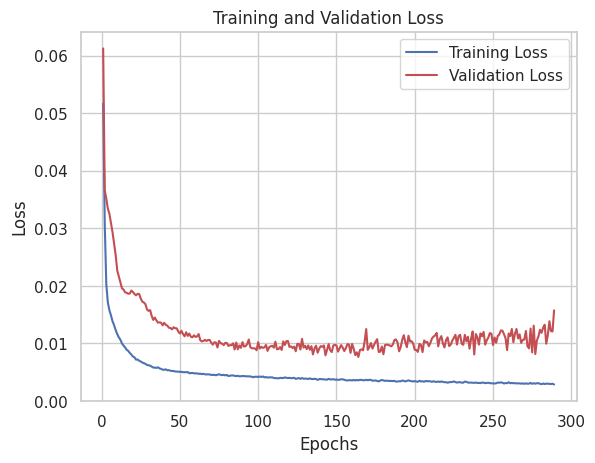

In [30]:
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Now use this trained model to predict the oil production on the test set

In [31]:
predictions = model.predict(test_set)

14/14 [==============================] - 0s 6ms/step


The below code concatenate the `X_test` with predicted data, reverse the scaling, and add `PREDICTED_OIL`, `PREDICTED_GAS`, and `PREDICTED_WATER` column to the data.

In [32]:
df_pred = pd.concat([pd.DataFrame(X_test[:,3:][window_size:]),pd.DataFrame(predictions)], axis = 1)
rev_trans = scaler.inverse_transform(df_pred)
df_final = data.iloc[-predictions.shape[0]:].copy()
df_final[['PREDICTED_OIL', 'PREDICTED_GAS', 'PREDICTED_WATER']] = rev_trans[:, -3:]

Let's plot the predicted and real data

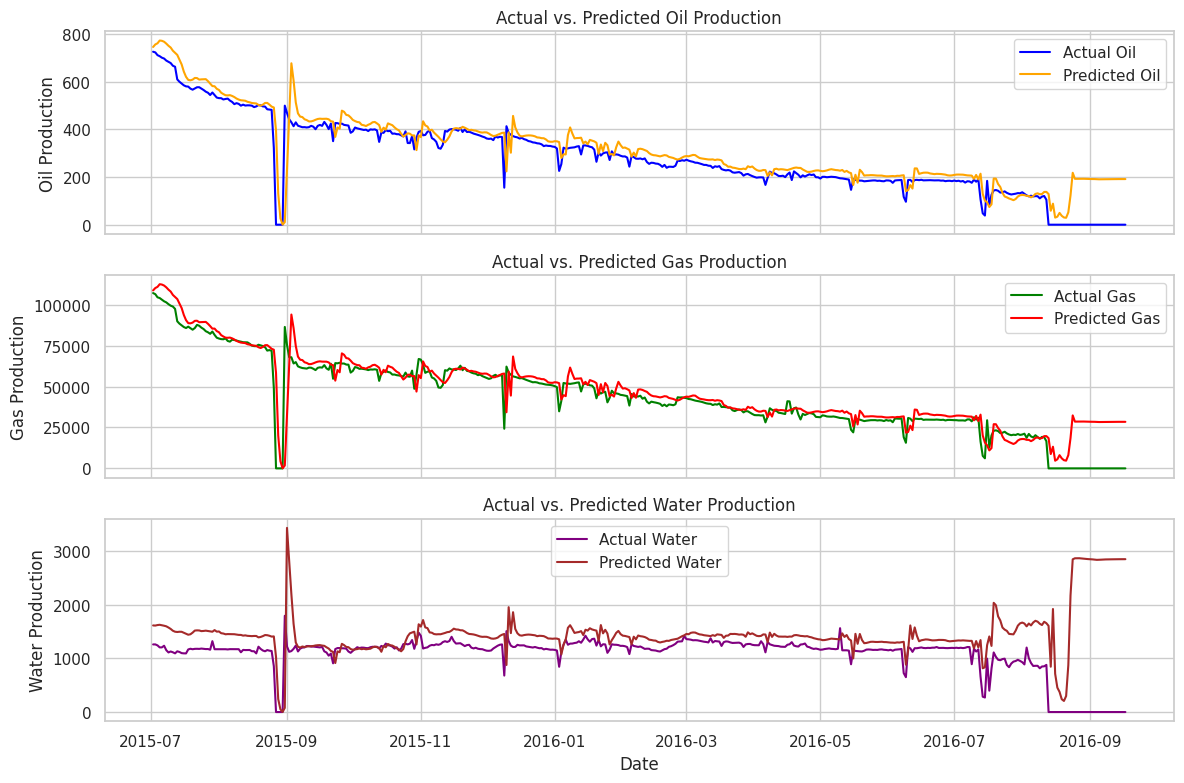

In [33]:
# Data
actual_oil = df_final['BORE_OIL_VOL']
predicted_oil = df_final['PREDICTED_OIL']
actual_gas = df_final['BORE_GAS_VOL']
predicted_gas = df_final['PREDICTED_GAS']
actual_water = df_final['BORE_WAT_VOL']
predicted_water = df_final['PREDICTED_WATER']
dates = df_final['DATEPRD']

fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# Subplot for Oil Production
sns.lineplot(data=df_final, x='DATEPRD', y='BORE_OIL_VOL', label='Actual Oil', ax=axs[0], color='blue')
sns.lineplot(data=df_final, x='DATEPRD', y='PREDICTED_OIL', label='Predicted Oil', ax=axs[0], color='orange')
axs[0].set_ylabel('Oil Production')
axs[0].set_title('Actual vs. Predicted Oil Production')
axs[0].legend()

# Subplot for Gas Production
sns.lineplot(data=df_final, x='DATEPRD', y='BORE_GAS_VOL', label='Actual Gas', ax=axs[1], color='green')
sns.lineplot(data=df_final, x='DATEPRD', y='PREDICTED_GAS', label='Predicted Gas', ax=axs[1], color='red')
axs[1].set_ylabel('Gas Production')
axs[1].set_title('Actual vs. Predicted Gas Production')
axs[1].legend()

# Subplot for Water Production
sns.lineplot(data=df_final, x='DATEPRD', y='BORE_WAT_VOL', label='Actual Water', ax=axs[2], color='purple')
sns.lineplot(data=df_final, x='DATEPRD', y='PREDICTED_WATER', label='Predicted Water', ax=axs[2], color='brown')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Water Production')
axs[2].set_title('Actual vs. Predicted Water Production')
axs[2].legend()

plt.tight_layout()
plt.show()

Alright! We have excellent predictions for oil and gas and some fair for water, though our model gone crazy at the tail of data. You may try further hyperparameters tunning to make it perfect for water as well.

To compare the actual and predicted data side by side, create a DataFrame named `compare_data` having columns `DATEPRD`, `BORE_OIL_VOL`, `PREDICTED_OIL`, `BORE_GAS_VOL`, `PREDICTED_GAS`, `BORE_WAT_VOL`, and `PREDICTED_WATER`.

In [34]:
compare_data = df_final[['DATEPRD', 'BORE_OIL_VOL', 'PREDICTED_OIL','BORE_GAS_VOL','PREDICTED_GAS', 'BORE_WAT_VOL', 'PREDICTED_WATER']]
compare_data

,DATEPRD,BORE_OIL_VOL,PREDICTED_OIL,BORE_GAS_VOL,PREDICTED_GAS,BORE_WAT_VOL,PREDICTED_WATER
4523,2015-07-02,726.33,746.273391,107230.62,108843.036474,1262.99,1617.446997
4524,2015-07-03,723.42,756.896641,106546.11,110304.975942,1263.02,1614.740089
4525,2015-07-04,711.93,761.724817,104631.50,111025.431890,1244.71,1624.478672
4526,2015-07-05,707.58,773.293117,104184.38,112644.804093,1207.33,1629.377394
4527,2015-07-06,701.27,772.170026,103160.24,112439.174867,1207.57,1621.146756
...,...,...,...,...,...,...,...
4962,2016-09-13,0.00,191.562763,0.00,28468.492582,0.00,2853.983097
4963,2016-09-14,0.00,191.579479,0.00,28470.071519,0.00,2854.105203
4964,2016-09-15,0.00,191.550259,0.00,28465.443709,0.00,2854.296649
4965,2016-09-16,0.00,191.598783,0.00,28472.407224,0.00,2854.694780


Before I close this discussion, please remember that to use this model for commercial purposes, it is extremely important to extract all the relevant features from both spatial and temporal dataset, as mentioned earlier.

Now it's your turn. Please try to train your own model, but instead of using only one well data, use the full set of data. Try hyperparameters tunings, like more epochs, layers, etc., to have good match.  

Best of Luck. . .